This Jupyter notebook contains analysis of accuracy differences between equiprobable and equidistant partitioning approaches, along with analysis of the source of differences in accuracy.

In [1]:
import scipy.stats as ss
import numpy as np
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble']=r'\usepackage{amsfonts}'
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times']
# Custom formatter to show scientific notation without offset
from matplotlib.ticker import FuncFormatter
def sci_formatter(x, significant_digits=1):
    s = f'{x:.{significant_digits}e}'
    s = s.replace('e+0', 'e').replace('e-0','e-').replace('e0','')
    return s
import matplotlib.pyplot as plt
import streaming_data_gsa as sdg
import os
from test_functions import polynomialSobols, Ishigami, spikeSlabPolynomial
from partition_analysis_methods import *

if not os.path.exists('figs'): os.mkdir('figs')

In [2]:
figdir='figs/partition_accuracy_comparisons/'
if not os.path.exists(figdir): os.makedirs(figdir)

In [3]:
urv = ss.uniform()
nrv = ss.norm()
erv = ss.expon()

In [4]:
upoly = polynomialSobols(1,1,10, 'uniform')
npoly = polynomialSobols(1,1,1,'normal')
epoly = polynomialSobols(1,1,10,'exponential')
ishigami = Ishigami( 7, 0.1 )
spike_slab = spikeSlabPolynomial()

Visualizing the partitioning approaches

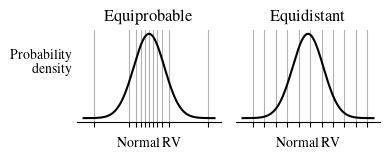

In [5]:
np.random.seed(20250402)
x = nrv.rvs(10000)
support = np.linspace(nrv.ppf(0.00001),nrv.ppf(0.99999), 1000)

fig = plt.figure(figsize=(4,1.7))
axs = fig.subplots(1,2,sharey=True)

nbins=10
prob_levels = np.linspace(0,1,nbins+1)
bin_edges = np.quantile(x,prob_levels)
axs[0].plot(support, nrv.pdf(support), 'k')
axs[0].set_xticks(bin_edges)
axs[0].grid(axis='x')
axs[0].set_axisbelow(True)
axs[0].set_xticklabels([]);
axs[0].spines[['left','top','right']].set_visible(False)
axs[0].set_yticks([])
axs[0].set_title('Equiprobable')

bin_edges = np.linspace(x.min(),x.max(),nbins+1)
axs[1].plot(support, nrv.pdf(support), 'k')
axs[1].set_xticks(bin_edges)
axs[1].grid(axis='x')
axs[1].set_axisbelow(True)
axs[1].set_xticklabels([]);
axs[1].spines[['left','top','right']].set_visible(False)
axs[1].set_yticks([])
axs[1].set_title('Equidistant')

axs[0].set_ylabel('Probability\ndensity', rotation=0, ha='right')
for ax in axs:
    ax.set_xlabel('Normal RV')

fig.tight_layout()
#fig.savefig(f'{figdir}/partition_illustration.png',dpi=300,transparent=True, bbox_inches='tight')
fig.savefig(f'{figdir}/partition_illustration.pdf', bbox_inches='tight')

Visualizing the spike-slab distribution we use in our comparisons. Note that because of its "spike" it doesn't admit an equiprobable partition.

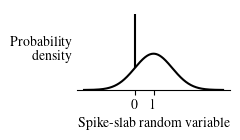

In [6]:
fig = spike_slab.plot_pdf();
fig.savefig(f'{figdir}/spike_slab_pdf.pdf',bbox_inches='tight')

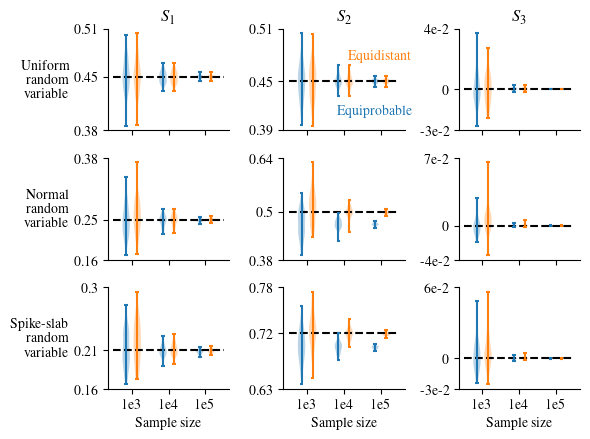

In [7]:
def equiprob_vs_equidist(model, axs, nbins=100, nsamples=[1000,10000,100000], nreps=100, seed=20250321, annotate=True):
    # It assumes you have passed a set of axs that will map to the number of variables.

    Strue = model.main_effects

    ep_sobols = np.zeros((len(nsamples),nreps,3))
    ed_sobols = np.zeros((len(nsamples),nreps,3))
    for i, ns in enumerate(nsamples):
        np.random.seed(seed)
        for j in range(nreps):
            x = model.generate_samples(ns)
            y = model.evaluate(x)
            mep = sdg.StreamingDataGSABatched(3,1,nbins,ns,binning_method='kde')
            med = sdg.StreamingDataGSABatched(3,1,nbins,ns,binning_method='dx')
            mep.process_samples(x,y)
            med.process_samples(x,y)
            ep_sobols[i,j] = mep.get_sobol_indices()
            ed_sobols[i,j] = med.get_sobol_indices()

    # now we want to plot comparisons of violins for equiprob vs equidist, one plot per variable, changing sample size
    inds = np.arange(len(nsamples))
    for i, St in enumerate(Strue):
        axs[i].hlines(St, -0.5, len(nsamples)-0.5, 'k', linestyles='--')
        axs[i].violinplot(ep_sobols[:,:,i].T, positions=inds-0.15, widths=0.2)
        axs[i].violinplot(ed_sobols[:,:,i].T, positions=inds+0.15, widths=0.2)
        axs[i].set_yticks([axs[i].get_ylim()[0], axs[i].get_ylim()[1], St])
        if i < 2:
            axs[i].set_yticklabels([ np.around(yt,2) for yt in axs[i].get_yticks()])
        if i>1:
            axs[i].set_yticklabels([sci_formatter(yt,0) for yt in axs[i].get_yticks()])
        axs[i].set_title(f'$S_{i+1}$')

    if annotate:
        axs[1].annotate('Equiprobable', (inds[1]-0.2, ep_sobols[1,:,1].min()-0.01), va='top', ha='left', color='C0')
        axs[1].annotate('Equidistant', (inds[1]+0.1, ed_sobols[1,:,1].max()+0.003), va='bottom', ha='left', color='C1')

    for ax in axs:
        ax.spines[['top','right']].set_visible(False)
        ax.set_xticks(inds)
        ax.set_xticklabels([sci_formatter(ns,0) for ns in nsamples])
        ax.set_xlabel('Sample size')

    if model.name=='Ishigami':
        fig.suptitle( r'\textbf{Ishigami function}', fontsize=10, x=0.5, ha='center')
    else:
        axs[0].set_ylabel( f'{model.dist_type.capitalize()}\nrandom\nvariable', rotation=0, ha='right', va='center')

fig = plt.figure(figsize=(6,4.5))
axs = fig.subplots(3, 3, sharex=True)

nreps=100
equiprob_vs_equidist(upoly, axs[0], nreps=nreps, nbins=50)
equiprob_vs_equidist(npoly, axs[1], nreps=nreps, nbins=50, annotate=False)
equiprob_vs_equidist(spike_slab, axs[2], nreps=nreps, nbins=50, annotate=False)

for ax in axs[1:].flatten():
    ax.set_title('')
for ax in axs[:-1].flatten():
    ax.set_xlabel('')

fig.tight_layout()
fig.savefig(f'{figdir}/sobol_convergence_partition_compare.pdf', bbox_inches='tight')

Now show how the estimator errors build up to the final error in the Sobol index

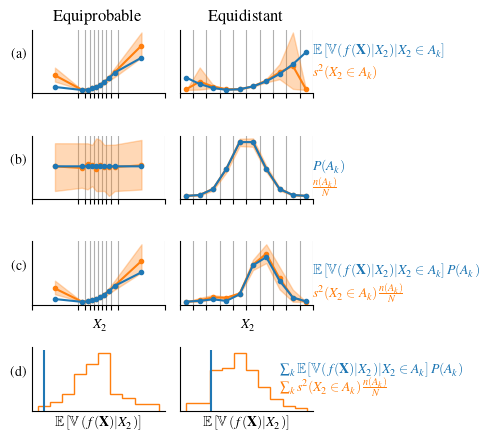

In [8]:
fig = plt.figure(figsize=(5,4.5))
axs = fig.subplots(4,2)
i=1

nsamples=1000
nreps=100
seed=20250402
model=npoly

prob_levels = np.linspace(0,1,11)
eprob_bin_edges = npoly.rv.ppf(prob_levels)
eprob_bin_edges[0] = npoly.rv.ppf(0.00001)
eprob_bin_edges[-1] = npoly.rv.ppf(1-0.00001)

plot_replicate_binned_stat_specified_bins(axs[0][0], model, i, nsamples, nreps, eprob_bin_edges, seed, 'inner_statistic_only')
plot_evf(axs[0][0], model, i, eprob_bin_edges, 'inner_statistic_only')

ax = axs[0][1]
edist_bin_edges = np.linspace(npoly.rv.ppf(0.00001),npoly.rv.ppf(1-0.00001), 11 )
avg_bin_edges = plot_replicate_binned_stat_specified_bins(ax, model, i, nsamples, nreps, edist_bin_edges, seed, 'inner_statistic_only')
plot_evf(ax, model, i, edist_bin_edges, 'inner_statistic_only')
ax.annotate(r'$\mathbb{E}\left[ \mathbb{V}(f(\mathbf{X}) | X_2) | X_2 \in A_k \right]$', (ax.get_xlim()[-1],22), color='C0', ha='left', va='center')
ax.annotate(r'$s^2(X_2 \in A_k)$', (ax.get_xlim()[-1],10), color='C1', ha='left', va='center')

plot_replicate_binned_stat_specified_bins(axs[1][0], model, i, nsamples, nreps, eprob_bin_edges, seed, 'bin_probabilities')
plot_evf(axs[1][0], model, i, eprob_bin_edges, 'bin_probabilities')

plot_replicate_binned_stat_specified_bins(axs[1][1], model, i, nsamples, nreps, edist_bin_edges, seed, 'bin_probabilities')
plot_evf(axs[1][1], model, i, edist_bin_edges, 'bin_probabilities')
ax = axs[1][1]
ax.annotate(r'$P(A_k)$', (ax.get_xlim()[-1], 0.125), color='C0', ha='left', va='bottom')
ax.annotate(r'$\frac{n(A_k)}{N}$', (ax.get_xlim()[-1], 0), color='C1', ha='left', va='bottom')

plot_replicate_binned_stat_specified_bins(axs[2][0], model, i, nsamples, nreps, eprob_bin_edges, seed, 'times_probability')
plot_evf(axs[2][0], model, i, eprob_bin_edges, 'times_probability')
plot_replicate_binned_stat_specified_bins(axs[2][1], model, i, nsamples, nreps, edist_bin_edges, seed, 'times_probability')
plot_evf(axs[2][1], model, i, edist_bin_edges, 'times_probability')

axs[2][1].annotate(r'$\mathbb{E}\left[ \mathbb{V}(f(\mathbf{X}) | X_2) | X_2 \in A_k \right] P(A_k)$', (axs[2][1].get_xlim()[-1],0.4), color='C0', ha='left', va='bottom')
axs[2][1].annotate(r'$s^2(X_2 \in A_k) \frac{n(A_k)}{N}$', (axs[2][1].get_xlim()[-1],0), va='bottom', ha='left', color='C1')


plot_replicate_binned_stat_specified_bins(axs[3][0], model, i, nsamples, nreps, eprob_bin_edges, seed, 'cumulative')
plot_evf(axs[3][0], model, i, eprob_bin_edges, 'cumulative')
plot_replicate_binned_stat_specified_bins(axs[3][1], model, i, nsamples, nreps, edist_bin_edges, seed, 'cumulative')
plot_evf(axs[3][1], model, i, edist_bin_edges, 'cumulative')

axs[3][1].annotate(r'$\sum_k \mathbb{E}\left[ \mathbb{V}(f(\mathbf{X}) | X_2) | X_2 \in A_k \right] P(A_k)$', (2.5,20), color='C0', ha='left', va='top')
axs[3][1].annotate(r'$\sum_k s^2(X_2 \in A_k) \frac{n(A_k)}{N} $', (2.5, 10), color='C1', ha='left', va='center')

for ax in axs[3]:
    ax.set_xlabel(r'$\mathbb{E}\left[ \mathbb{V}\left(f(\mathbf{X}) | X_2 \right) \right]$')
    ax.set_xticks([])

axs[0][0].set_title("Equiprobable")
axs[0][1].set_title("Equidistant")

for ax in axs.flatten()[:4]:
    ax.set_xlabel('')

for ax in axs.flatten():
    ax.set_yticks([])


for label, ax in zip(['(a)','(b)','(c)','(d)'], axs.T[0]):
    ax.set_ylabel(label, rotation=0, ha='right')

fig.tight_layout()
fig.savefig(f'{figdir}/steps_in_partition_compare.pdf', bbox_inches='tight')

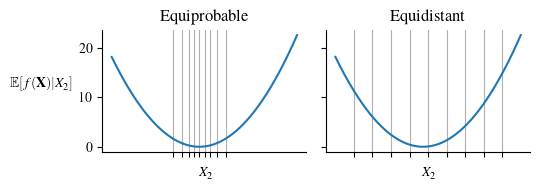

In [9]:
fig = plt.figure(figsize=(5.5,2))
axs = fig.subplots(1,2,sharey=True)

x = np.linspace(npoly.rv.ppf(0.00001), npoly.rv.ppf(0.999999), 1000)
y = npoly.E2fun(x)

prob_levels = np.linspace(0,1,11)[1:-1]
bin_edges = npoly.rv.ppf(prob_levels)
axs[0].plot(x,y)
axs[0].set_xticks(bin_edges)
axs[0].set_ylabel(r'$\mathbb{E}[f(\mathbf{X})|X_2]$', rotation=0, ha='right')
axs[0].set_title("Equiprobable")

bin_edges = np.linspace(npoly.rv.ppf(0.00001), npoly.rv.ppf(0.999999), 11)[1:-1] 
axs[1].plot(x,y)
axs[1].set_xticks(bin_edges)
axs[1].set_title("Equidistant")

for ax in axs:
    ax.set_xlabel(r'$X_2$')
    ax.spines[['top','right']].set_visible(False)
    ax.grid(axis='x')
    ax.set_axisbelow(True)
    ax.set_xticklabels([])

fig.tight_layout()
fig.savefig(f'{figdir}/normalPolynomial_E2_partition_compare.pdf', bbox_inches='tight')